In [1]:
import numpy as np
import pandas as pd
import polars as pl
from scipy.stats import friedmanchisquare, kruskal, rankdata
from scikit_posthocs import posthoc_dunn
import scikit_posthocs as sp

In [2]:
files = [
    ("unbalanced_2DCNN_metrics_output.csv", "2DCNN"),
    ("unbalanced_AE_metrics_output.csv", "AE"),
    ("unbalanced_bayes_metrics_output.csv", "Bayes"),
    ("unbalanced_dt_metrics_output.csv", "DT"),
    ("unbalanced_knn_metrics_output.csv", "KNN"),
    ("unbalanced_lr_metrics_output.csv", "LR"),
    ("unbalanced_mlp_metrics_output.csv", "MLP"),
    ("unbalanced_rf_metrics_output.csv", "RF"),
    ("unbalanced_svm_metrics_output.csv", "SVM"),
]

In [3]:
selected_metric = "Balanced Accuracy" 
metric_data = {
    model_name: pl.read_csv(file, separator=";")[selected_metric].to_list()
    for file, model_name in files
}

In [4]:
# Teste de Friedman
def friedman_test(data):
    model_values = list(data.values())
    stat, p_value = friedmanchisquare(*model_values)
    return stat, p_value

# Teste de Kruskal-Wallis
def kruskal_test(data):
    model_values = list(data.values())
    stat, p_value = kruskal(*model_values)
    return stat, p_value

# Teste Pós-Hoc de Dunn
def dunn_posthoc(metric_data, p_adjust):
    all_data = pd.concat(
    [pd.DataFrame({"Model": model, selected_metric: values}) for model, values in metric_data.items()],
    ignore_index=True,
)
    return posthoc_dunn(all_data, val_col=selected_metric, group_col="Model", p_adjust=p_adjust)

def calcular_ranks_do_csv(file_path):
    df = pd.read_csv(file_path, delimiter=";")
    if selected_metric not in df.columns:
        raise ValueError(f"A métrica {selected_metric} não foi encontrada nas colunas do CSV.")
    df['Rank'] = rankdata(-df[selected_metric])
    return df[['Algorithm', selected_metric, 'Rank']].sort_values(by='Rank', ascending=True)

def compararPorAlgoritmo(algorithm):
    return df_all[df_all['Algorithm 1'] == algorithm]

In [5]:
file_path = '_unbalanced_mean_metrics_output.csv'
calcular_ranks_do_csv(file_path)

,Algorithm,Balanced Accuracy,Rank
5,DT,0.996842,1.0
3,RF,0.996740,2.0
0,KNN,0.994422,3.0
7,MLP,0.994214,4.0
8,2DCNN,0.991655,5.0
1,LR,0.969066,6.0
6,AE,0.967630,7.0
4,Bayes,0.966421,8.0
2,SVM,0.937955,9.0


In [7]:
stat, p_value = friedman_test(metric_data)
print(f"Teste de Friedman para {selected_metric}")
print(f"Estatística de teste: {stat}")
print(f"P-valor: {p_value}")

Teste de Friedman para Balanced Accuracy
Estatística de teste: 73.17333333333335
P-valor: 1.1441957078844597e-12


In [8]:
if p_value < 0.05:
    print(f"Há diferenças estatisticamente significativas entre os modelos para '{selected_metric}'.")
    posthoc_results = dunn_posthoc(metric_data, p_adjust="fdr_bh")
    print("Resultados do teste pós-hoc de Dunn:")
    print(posthoc_results)
else:
    print(f"Não há diferenças estatisticamente significativas entre os modelos para '{selected_metric}'.")


Há diferenças estatisticamente significativas entre os modelos para 'Balanced Accuracy'.
Resultados do teste pós-hoc de Dunn:
          2DCNN            AE         Bayes            DT       KNN        LR  \
2DCNN  1.000000  9.959906e-02  2.474235e-02  9.597186e-04  0.108928  0.271668   
AE     0.099599  1.000000e+00  5.927824e-01  5.420724e-07  0.000737  0.593522   
Bayes  0.024742  5.927824e-01  1.000000e+00  4.407192e-08  0.000078  0.312203   
DT     0.000960  5.420724e-07  4.407192e-08  1.000000e+00  0.112536  0.000007   
KNN    0.108928  7.367564e-04  7.800359e-05  1.125365e-01  1.000000  0.004536   
LR     0.271668  5.935225e-01  3.122033e-01  7.360105e-06  0.004536  1.000000   
MLP    0.351338  6.699495e-03  9.597186e-04  2.474235e-02  0.531177  0.030491   
RF     0.013052  2.037127e-05  1.600615e-06  4.704498e-01  0.441038  0.000222   
SVM    0.068495  8.573540e-01  6.877850e-01  2.903583e-07  0.000394  0.518165   

            MLP        RF           SVM  
2DCNN  0.351338  0.01

In [9]:
# Definir o nível de significância
alpha = 0.05

# Obter todos os pares possíveis (incluindo duplicações)
all_pairs = np.indices(posthoc_results.shape)  # Inclui todos os pares (toda a matriz)
all_results = []

# Gerar uma lista legível com todos os pares
for i, j in zip(all_pairs[0].flatten(), all_pairs[1].flatten()):
    model_i = posthoc_results.index[i]
    model_j = posthoc_results.columns[j]
    p_value = posthoc_results.iloc[i, j]
    significance = 'Significativo' if p_value < alpha else 'Não Significativo'
    all_results.append((model_i, model_j, p_value, significance))

# Criar um DataFrame para exibir os resultados como tabela
df_all = pd.DataFrame(all_results, columns=['Algorithm 1', 'Algorithm 2', 'p-value', 'Significância'])

# Exibir a tabela
print("Pares com resultados e significância")
print(df_all)


Pares com resultados e significância
   Algorithm 1 Algorithm 2   p-value      Significância
0        2DCNN       2DCNN  1.000000  Não Significativo
1        2DCNN          AE  0.099599  Não Significativo
2        2DCNN       Bayes  0.024742      Significativo
3        2DCNN          DT  0.000960      Significativo
4        2DCNN         KNN  0.108928  Não Significativo
..         ...         ...       ...                ...
76         SVM         KNN  0.000394      Significativo
77         SVM          LR  0.518165  Não Significativo
78         SVM         MLP  0.004201      Significativo
79         SVM          RF  0.000010      Significativo
80         SVM         SVM  1.000000  Não Significativo

[81 rows x 4 columns]


In [10]:
compararPorAlgoritmo('DT')

,Algorithm 1,Algorithm 2,p-value,Significância
27,DT,2DCNN,9.597186e-04,Significativo
28,DT,AE,5.420724e-07,Significativo
29,DT,Bayes,4.407192e-08,Significativo
30,DT,DT,1.000000e+00,Não Significativo
31,DT,KNN,1.125365e-01,Não Significativo
32,DT,LR,7.360105e-06,Significativo
33,DT,MLP,2.474235e-02,Significativo
34,DT,RF,4.704498e-01,Não Significativo
35,DT,SVM,2.903583e-07,Significativo


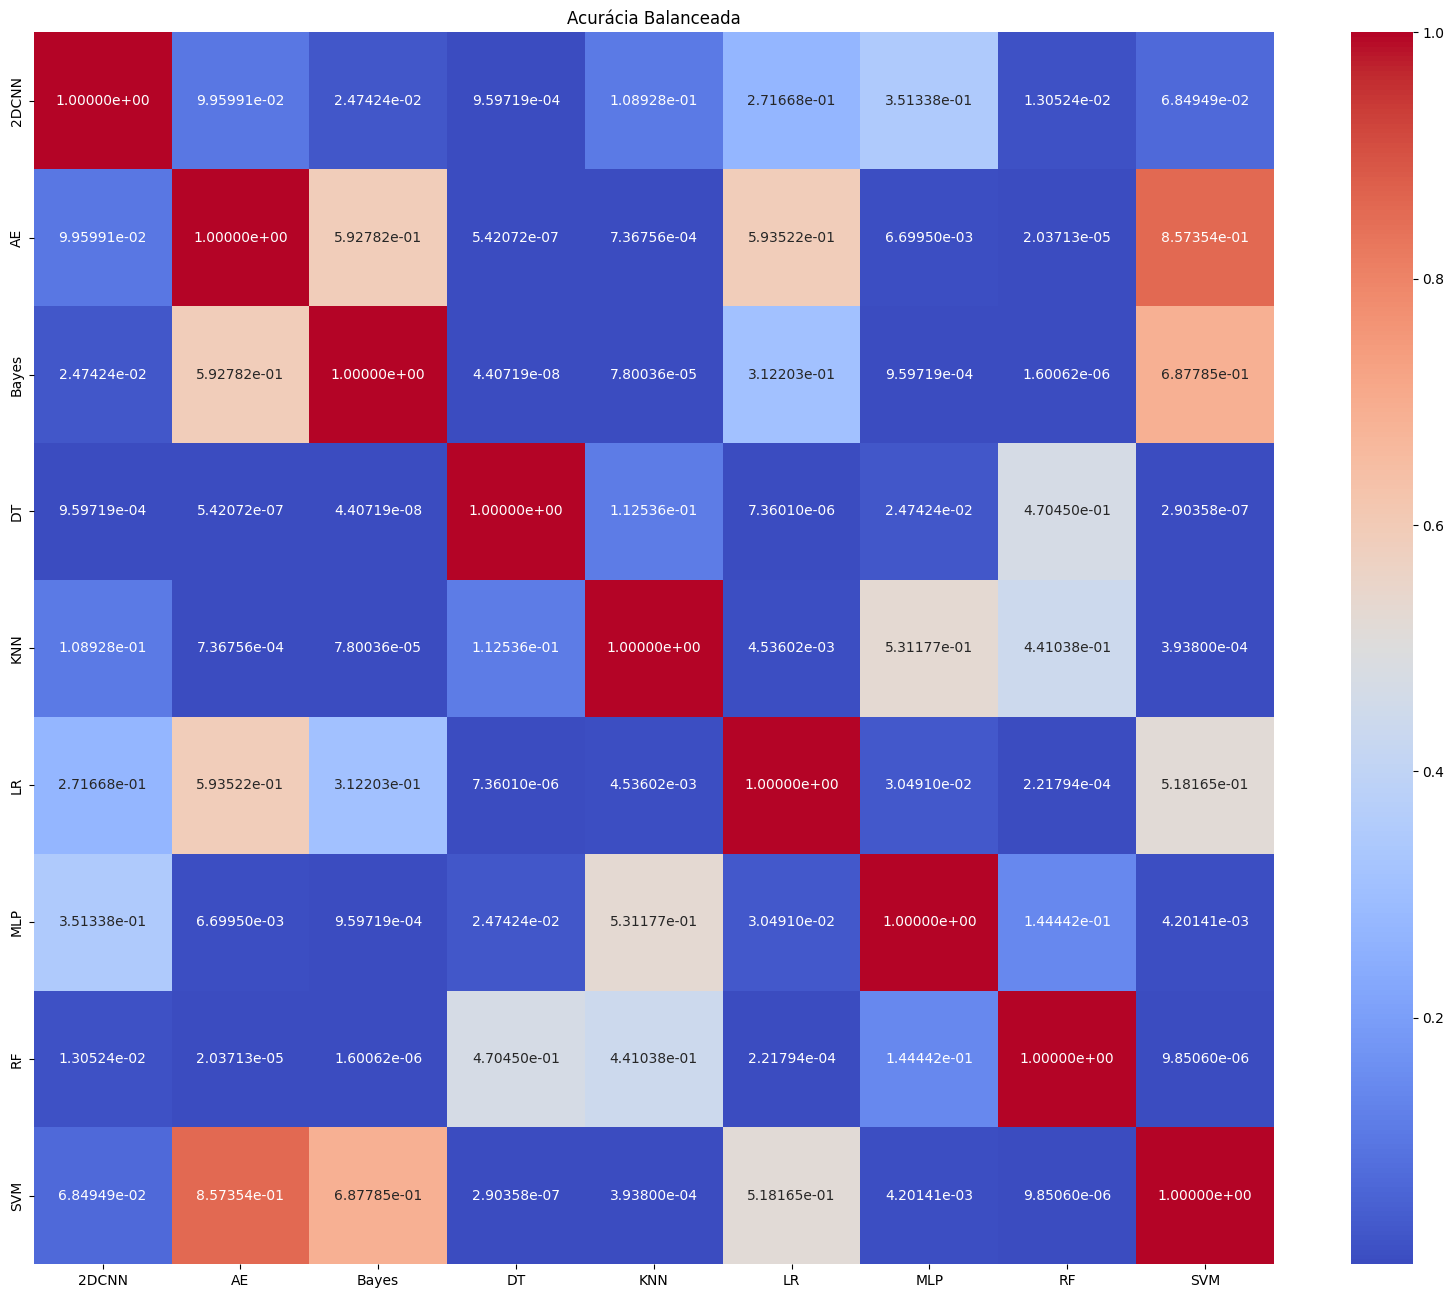

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Definindo o formato como notação científica
plt.figure(figsize=(20, 16))
sns.heatmap(posthoc_results, annot=True, fmt=".5e", cmap="coolwarm", cbar=True)  # .2e para notação científica
plt.title(f"Acurácia Balanceada")

# Salvando a figura como um PDF
plt.savefig(f"{selected_metric}_heat_map.pdf", format="pdf")

# Mostrando o gráfico
plt.show()


In [12]:
selected_metric = "F1-score" 
metric_data = {
    model_name: pl.read_csv(file, separator=";")[selected_metric].to_list()
    for file, model_name in files
}

In [13]:
file_path = '_unbalanced_mean_metrics_output.csv'
calcular_ranks_do_csv(file_path)

,Algorithm,F1-score,Rank
5,DT,0.997033,1.0
3,RF,0.997023,2.0
0,KNN,0.995305,3.0
7,MLP,0.995273,4.0
8,2DCNN,0.994451,5.0
4,Bayes,0.989166,6.0
1,LR,0.987994,7.0
6,AE,0.987869,8.0
2,SVM,0.969000,9.0


In [15]:
stat, p_value = friedman_test(metric_data)
print(f"Teste de Friedman para {selected_metric}")
print(f"Estatística de teste: {stat}")
print(f"P-valor: {p_value}")

Teste de Friedman para F1-score
Estatística de teste: 73.52000000000004
P-valor: 9.754577658306242e-13


In [16]:
if p_value < 0.05:
    print(f"Há diferenças estatisticamente significativas entre os modelos para '{selected_metric}'.")
    posthoc_results = dunn_posthoc(metric_data, p_adjust="fdr_bh")
    print("Resultados do teste pós-hoc de Dunn:")
    print(posthoc_results)
else:
    print(f"Não há diferenças estatisticamente significativas entre os modelos para '{selected_metric}'.")


Há diferenças estatisticamente significativas entre os modelos para 'F1-score'.
Resultados do teste pós-hoc de Dunn:
          2DCNN        AE     Bayes            DT       KNN            LR  \
2DCNN  1.000000  0.140122  0.154207  1.304749e-03  0.131177  2.139116e-02   
AE     0.140122  1.000000  0.931789  1.836644e-06  0.001821  4.704334e-01   
Bayes  0.154207  0.931789  1.000000  2.319599e-06  0.002306  4.300487e-01   
DT     0.001305  0.000002  0.000002  1.000000e+00  0.120480  5.164973e-08   
KNN    0.131177  0.001821  0.002306  1.204800e-01  1.000000  8.082144e-05   
LR     0.021391  0.470433  0.430049  5.164973e-08  0.000081  1.000000e+00   
MLP    0.374419  0.013160  0.015145  2.647771e-02  0.579777  9.940529e-04   
RF     0.014105  0.000058  0.000075  4.889694e-01  0.417792  1.836644e-06   
SVM    0.053155  0.668863  0.624137  2.497568e-07  0.000367  7.266435e-01   

            MLP        RF           SVM  
2DCNN  0.374419  0.014105  5.315483e-02  
AE     0.013160  0.000058  6

In [17]:
# Definir o nível de significância
alpha = 0.05

# Obter todos os pares possíveis (incluindo duplicações)
all_pairs = np.indices(posthoc_results.shape)  # Inclui todos os pares (toda a matriz)
all_results = []

# Gerar uma lista legível com todos os pares
for i, j in zip(all_pairs[0].flatten(), all_pairs[1].flatten()):
    model_i = posthoc_results.index[i]
    model_j = posthoc_results.columns[j]
    p_value = posthoc_results.iloc[i, j]
    significance = 'Significativo' if p_value < alpha else 'Não Significativo'
    all_results.append((model_i, model_j, p_value, significance))

# Criar um DataFrame para exibir os resultados como tabela
df_all = pd.DataFrame(all_results, columns=['Algorithm 1', 'Algorithm 2', 'p-value', 'Significância'])

# Exibir a tabela
print("Pares com resultados e significância")
print(df_all)


Pares com resultados e significância
   Algorithm 1 Algorithm 2   p-value      Significância
0        2DCNN       2DCNN  1.000000  Não Significativo
1        2DCNN          AE  0.140122  Não Significativo
2        2DCNN       Bayes  0.154207  Não Significativo
3        2DCNN          DT  0.001305      Significativo
4        2DCNN         KNN  0.131177  Não Significativo
..         ...         ...       ...                ...
76         SVM         KNN  0.000367      Significativo
77         SVM          LR  0.726643  Não Significativo
78         SVM         MLP  0.002915      Significativo
79         SVM          RF  0.000007      Significativo
80         SVM         SVM  1.000000  Não Significativo

[81 rows x 4 columns]


In [18]:
compararPorAlgoritmo('DT')

,Algorithm 1,Algorithm 2,p-value,Significância
27,DT,2DCNN,1.304749e-03,Significativo
28,DT,AE,1.836644e-06,Significativo
29,DT,Bayes,2.319599e-06,Significativo
30,DT,DT,1.000000e+00,Não Significativo
31,DT,KNN,1.204800e-01,Não Significativo
32,DT,LR,5.164973e-08,Significativo
33,DT,MLP,2.647771e-02,Significativo
34,DT,RF,4.889694e-01,Não Significativo
35,DT,SVM,2.497568e-07,Significativo


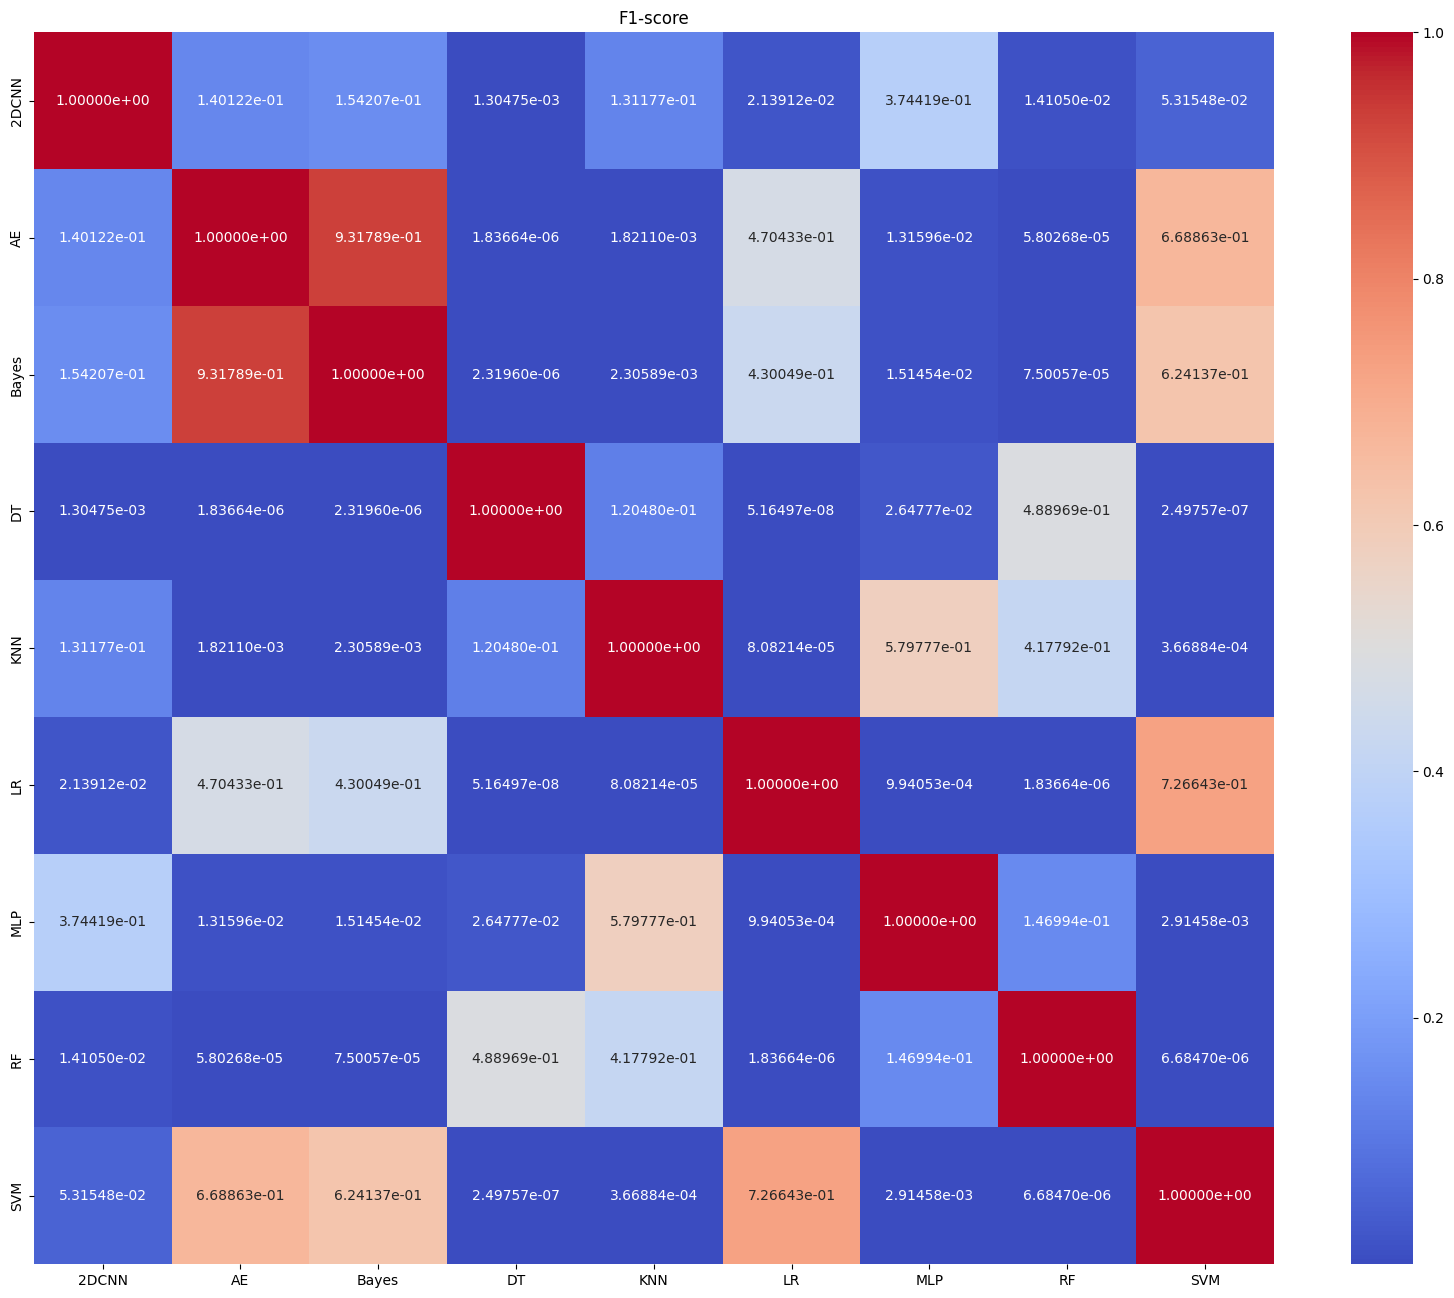

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Definindo o formato como notação científica
plt.figure(figsize=(20, 16))
sns.heatmap(posthoc_results, annot=True, fmt=".5e", cmap="coolwarm", cbar=True)  # .2e para notação científica
plt.title(f"{selected_metric}")

# Salvando a figura como um PDF
plt.savefig(f"{selected_metric}_heat_map.pdf", format="pdf")

# Mostrando o gráfico
plt.show()
